In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F 

import numpy as np
import pandas as pd
import yfinance as yf
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ISM_df = pd.read_excel("ISM.xlsx")
ISM_df["Release Date"].value_counts()

Release Date
May 01, 2023 (Apr)     1
2010-07-01 00:00:00    1
2010-05-03 00:00:00    1
2010-04-01 00:00:00    1
2010-03-01 00:00:00    1
                      ..
Mar 01, 2016 (Feb)     1
Feb 01, 2016 (Jan)     1
Jan 04, 2016 (Dec)     1
Dec 01, 2015 (Nov)     1
Dec 01, 2002 (Nov)     1
Name: count, Length: 246, dtype: int64

In [3]:
date_list = []

# 發現比用pd.to_datetime or Series.apply還好用，直接依照邏輯更改成自己要的格式
for d in ISM_df["Release Date"].values:
    if type(d) == str:
        date_list.append(datetime.datetime.strptime(d[:-6], "%b %d, %Y"))
    else:
        date_list.append(d)
        
ISM_df["Date"] = date_list
ISM_df.rename(columns = {"Actual": "ISM"}, inplace = True)
ISM_df = ISM_df[["Date", "ISM"]]
ISM_df["Date"] = ISM_df["Date"].values.astype("datetime64[D]")
ISM_df.head()

,Date,ISM
0,2023-05-01,NaN
1,2023-04-03,46.3
2,2023-03-01,47.7
3,2023-02-01,47.4
4,2023-01-04,48.4


In [4]:
unemp_df = pd.read_excel("unemploy.xlsx")

date_list_ = []
for d in unemp_df["Release Date"].values:
    if type(d) == str:
        date_list_.append(datetime.datetime.strptime(d[:-6], "%b %d, %Y"))
    else:
        date_list_.append(d)
        
unemp_df["Date"] = date_list_

unemp_df.rename(columns = {"Actual": "UNEMP"}, inplace = True)
unemp_df = unemp_df[["Date", "UNEMP"]]
unemp_df["Date"] = unemp_df["Date"].values.astype("datetime64[D]")

In [5]:
import quandl
import os
from dotenv import load_dotenv
load_dotenv()

quandl.ApiConfig.api_key = os.getenv("QUANDLAPI")

# 不是我一開始不用這些可以取得美國經濟數據的api，是相關我需要的api這邊無法提供，僅找到通膨的代碼
cpi_df = quandl.get("RATEINF/INFLATION_USA")
cpi_df.head()

,Value
Date,
1914-01-31,2.041
1914-02-28,1.020
1914-03-31,1.020
1914-04-30,0.000
1914-05-31,2.062


In [6]:
cpi_df.reset_index(inplace = True)
cpi_df["Date"] = cpi_df["Date"].values.astype("datetime64[D]")
cpi_df.rename(columns={"Value": "CPI"}, inplace = True)

In [7]:
qqq_df = yf.Ticker("QQQ").history(period="20y")
qqq_df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2003-04-29 00:00:00-04:00,23.729608,24.090188,23.532148,23.806875,79903800,0.0,0.0,0.0
2003-04-30 00:00:00-04:00,23.738188,23.858383,23.549314,23.566484,60202100,0.0,0.0,0.0
2003-05-01 00:00:00-04:00,23.557899,23.927064,23.343268,23.772530,66022600,0.0,0.0,0.0
2003-05-02 00:00:00-04:00,23.703845,24.287642,23.669504,24.279057,85004100,0.0,0.0,0.0
2003-05-05 00:00:00-04:00,24.321991,24.648230,24.184627,24.253309,80520300,0.0,0.0,0.0


In [8]:
qqq_df.reset_index(inplace = True)
qqq_df["Date"] = qqq_df["Date"].values.astype("datetime64[D]")

# 在合併前先整理qqq_df  =>  擷取只要的欄位 + 整理一下價格

# 順移前一天的股價，比對看看是否隔天的收盤價因為發放股利而減少
qqq_df["former_Close"] = qqq_df["Close"].shift(1, axis = 0)
qqq_df["rational_Close"] = qqq_df["former_Close"] - qqq_df["Dividends"]
gap_list = qqq_df["Close"] - qqq_df["rational_Close"]
gap_list.describe()

count    5035.000000
mean        0.062826
std         2.217138
min       -22.597946
25%        -0.358416
50%         0.075401
75%         0.515170
max        19.353638
dtype: float64

In [9]:
qqq_df = qqq_df[["Date", "Close", "Volume"]]
len(qqq_df)

5036

In [10]:
merge_df = pd.merge(qqq_df, ISM_df, on='Date', how='outer')
print(len(merge_df))
merge_df

5062


,Date,Close,Volume,ISM
0,2003-04-29,23.806875,79903800.0,NaN
1,2003-04-30,23.566484,60202100.0,NaN
2,2003-05-01,23.772530,66022600.0,46.1
3,2003-05-02,24.279057,85004100.0,NaN
4,2003-05-05,24.253309,80520300.0,NaN
...,...,...,...,...
5057,2003-04-01,NaN,NaN,46.3
5058,2003-03-01,NaN,NaN,48.8
5059,2003-02-01,NaN,NaN,51.3
5060,2003-01-01,NaN,NaN,51.6


In [11]:
merge_df = merge_df[:len(qqq_df)]
merge_df["ISM"] = merge_df["ISM"].fillna(method = "ffill")
merge_df

/tmp/ipykernel_19154/1545029379.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merge_df["ISM"] = merge_df["ISM"].fillna(method = "ffill")


,Date,Close,Volume,ISM
0,2003-04-29,23.806875,79903800.0,NaN
1,2003-04-30,23.566484,60202100.0,NaN
2,2003-05-01,23.772530,66022600.0,46.1
3,2003-05-02,24.279057,85004100.0,46.1
4,2003-05-05,24.253309,80520300.0,46.1
...,...,...,...,...
5031,2023-04-24,315.950012,44043100.0,46.3
5032,2023-04-25,309.989990,57121600.0,46.3
5033,2023-04-26,311.869995,55400500.0,46.3
5034,2023-04-27,320.350006,65430400.0,46.3


In [12]:
merge_df = pd.merge(merge_df, unemp_df, on='Date', how='outer')
merge_df = merge_df[:len(qqq_df)]
merge_df["UNEMP"] = merge_df["UNEMP"].fillna(method = "ffill")

merge_df = pd.merge(merge_df, cpi_df, on='Date', how='outer')
merge_df = merge_df[:len(qqq_df)]
merge_df["CPI"] = merge_df["CPI"].fillna(method = "ffill")

print(len(merge_df))
print(merge_df)

merge_df = merge_df.dropna()
merge_df = merge_df.set_index("Date")
print(len(merge_df))

5036
           Date       Close      Volume   ISM  UNEMP    CPI
0    2003-04-29   23.806875  79903800.0   NaN    NaN    NaN
1    2003-04-30   23.566484  60202100.0   NaN    NaN  2.225
2    2003-05-01   23.772530  66022600.0  46.1  0.060  2.225
3    2003-05-02   24.279057  85004100.0  46.1  0.060  2.225
4    2003-05-05   24.253309  80520300.0  46.1  0.060  2.225
...         ...         ...         ...   ...    ...    ...
5031 2023-04-24  315.950012  44043100.0  46.3  0.036  4.985
5032 2023-04-25  309.989990  57121600.0  46.3  0.036  4.985
5033 2023-04-26  311.869995  55400500.0  46.3  0.036  4.985
5034 2023-04-27  320.350006  65430400.0  46.3  0.036  4.985
5035 2023-04-28  322.559998  59652500.0  46.3  0.036  4.985

[5036 rows x 6 columns]
5034


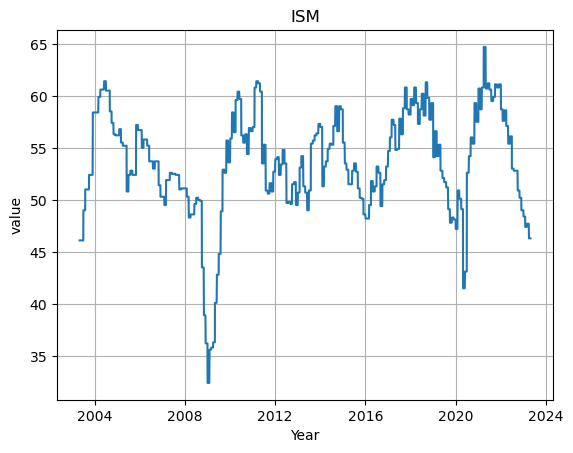

In [15]:
plt.grid(True)
plt.ylabel("value")
plt.xlabel("Year")
plt.plot(merge_df["ISM"])
plt.title('ISM')
plt.show()

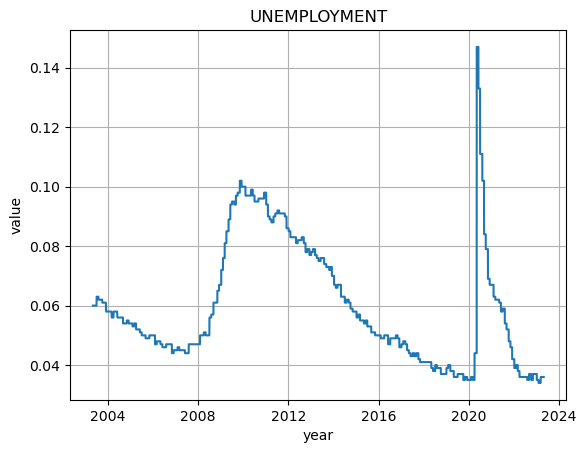

In [16]:
plt.grid(True)
plt.ylabel("value")
plt.xlabel("year")
plt.plot(merge_df["UNEMP"])
plt.title('UNEMPLOYMENT')
plt.show()

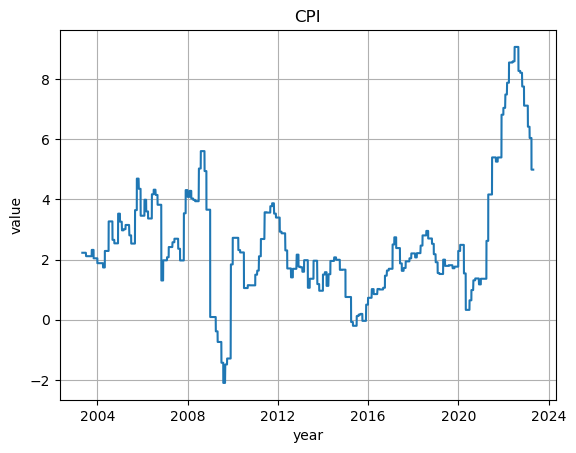

In [17]:
plt.grid(True)
plt.ylabel("value")
plt.xlabel("year")
plt.plot(merge_df["CPI"])
plt.title('CPI')
plt.show()

In [18]:
merge_df.drop(["UNEMP"], axis = 1, inplace = True)

In [19]:
merge_df.loc[merge_df["ISM"] < 50, "ISM"] = 0
merge_df.loc[merge_df["ISM"] >= 50, "ISM"] = 1
merge_df["ISM"] = merge_df["ISM"].astype(int)

In [20]:
merge_df["avg_10_Close"] = merge_df["Close"].rolling(10).sum()/10
merge_df["avg_10_Close"] = merge_df["avg_10_Close"].shift(-10, axis = 0)

merge_df["avg_30_Close"] = merge_df["Close"].rolling(30).sum()/30
merge_df["avg_30_Close"] = merge_df["avg_30_Close"].shift(-30, axis = 0)

merge_df["avg_60_Close"] = merge_df["Close"].rolling(60).sum()/60
merge_df["avg_60_Close"] = merge_df["avg_60_Close"].shift(-60, axis = 0)

merge_df

,Close,Volume,ISM,CPI,avg_10_Close,avg_30_Close,avg_60_Close
Date,,,,,,,
2003-05-01,23.772530,66022600.0,0,2.225,24.436173,24.946710,25.808668
2003-05-02,24.279057,85004100.0,0,2.225,24.472232,25.021116,25.856888
2003-05-05,24.253309,80520300.0,0,2.225,24.424154,25.092946,25.902247
2003-05-06,24.562370,77338300.0,0,2.225,24.352040,25.159052,25.947892
2003-05-07,24.287651,70353200.0,0,2.225,24.300528,25.220007,25.993251
...,...,...,...,...,...,...,...
2023-04-24,315.950012,44043100.0,0,4.985,NaN,NaN,NaN
2023-04-25,309.989990,57121600.0,0,4.985,NaN,NaN,NaN
2023-04-26,311.869995,55400500.0,0,4.985,NaN,NaN,NaN


In [21]:
merge_df.dropna(inplace = True)

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler_c = MinMaxScaler(feature_range=(0, 1))
scaler_c_10 = MinMaxScaler(feature_range=(0, 1)) 
scaler_c_30 = MinMaxScaler(feature_range=(0, 1)) 
scaler_c_60 = MinMaxScaler(feature_range=(0, 1)) 

# 正常來講要使用train的，validation跟test配合該正規化的參數，同時忽略離群值
# 但由於2020/3月後是大牛市，train只到2019年，這些離群值不再離群了，因此採用"所有資料"做正規化
# 後續再分別train / validation / test套用同一正規化處理  =>  股市長期還是會漲，因此可能需要長期持續重新正規化才比較準確
merge_df["Close"] = scaler_c.fit_transform(merge_df["Close"].values.reshape(-1, 1))
merge_df["avg_10_Close"] = scaler_c_10.fit_transform(merge_df["avg_10_Close"].values.reshape(-1, 1))
merge_df["avg_30_Close"] = scaler_c_30.fit_transform(merge_df["avg_30_Close"].values.reshape(-1, 1))
merge_df["avg_60_Close"] = scaler_c_60.fit_transform(merge_df["avg_60_Close"].values.reshape(-1, 1))

In [23]:
merge_df

,Close,Volume,ISM,CPI,avg_10_Close,avg_30_Close,avg_60_Close
Date,,,,,,,
2003-05-01,0.003578,66022600.0,0,2.225,0.002040,0.000000,0.000629
2003-05-02,0.004920,85004100.0,0,2.225,0.002137,0.000203,0.000762
2003-05-05,0.004852,80520300.0,0,2.225,0.002008,0.000400,0.000888
2003-05-06,0.005670,77338300.0,0,2.225,0.001813,0.000580,0.001014
2003-05-07,0.004943,70353200.0,0,2.225,0.001675,0.000747,0.001139
...,...,...,...,...,...,...,...
2023-01-26,0.716487,51596300.0,0,7.110,0.748588,0.747456,0.773132
2023-01-27,0.724210,56441900.0,0,7.110,0.749514,0.746950,0.773786
2023-01-30,0.708367,49405800.0,0,7.110,0.753342,0.747596,0.774801


In [24]:
validation_size = test_size = int(len(merge_df)/10)

# 需特別注意是否有切對，避免使用到validation_data跟test_data進行訓練
train_size = len(merge_df) - validation_size - test_size
train_data = merge_df[:train_size]
validation_data = merge_df[train_size:train_size+validation_size]
test_data = merge_df[train_size+validation_size:]

print(len(train_data))
print(len(validation_data))
print(len(test_data))

3980
497
497


In [25]:
train_data["Volume"] = train_data["Volume"].astype(int)
train_data["VolumeBand"] = pd.qcut(train_data["Volume"], 4)
train_data["VolumeBand"].value_counts().sort_values()

/tmp/ipykernel_19154/1172596487.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["Volume"] = train_data["Volume"].astype(int)
/tmp/ipykernel_19154/1172596487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["VolumeBand"] = pd.qcut(train_data["Volume"], 4)


VolumeBand
(7079299.999, 32560400.0]     995
(32560400.0, 63623300.0]      995
(63623300.0, 101376750.0]     995
(101376750.0, 616772300.0]    995
Name: count, dtype: int64

In [26]:
combine = [train_data, validation_data, test_data]

for dataset in combine:
    dataset.loc[dataset["Volume"] <= 32560400, "Volume"] = 0
    dataset.loc[(dataset["Volume"] > 32560400) & (dataset["Volume"] <= 63623300) , "Volume"] = 1
    dataset.loc[(dataset["Volume"] > 63623300) & (dataset["Volume"] <= 101376750) , "Volume"] = 2
    dataset.loc[(dataset["Volume"] > 101376750) , "Volume"] = 3
    dataset["Volume"] = dataset["Volume"].astype(int)
    
train_data.drop("VolumeBand", axis = 1, inplace = True)

/tmp/ipykernel_19154/586540095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Volume"] = dataset["Volume"].astype(int)
/tmp/ipykernel_19154/586540095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Volume"] = dataset["Volume"].astype(int)
/tmp/ipykernel_19154/586540095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [27]:
train_data.head()

,Close,Volume,ISM,CPI,avg_10_Close,avg_30_Close,avg_60_Close
Date,,,,,,,
2003-05-01,0.003578,2,0,2.225,0.002040,0.000000,0.000629
2003-05-02,0.004920,2,0,2.225,0.002137,0.000203,0.000762
2003-05-05,0.004852,2,0,2.225,0.002008,0.000400,0.000888
2003-05-06,0.005670,2,0,2.225,0.001813,0.000580,0.001014
2003-05-07,0.004943,2,0,2.225,0.001675,0.000747,0.001139


In [28]:
train_data["CPI"] = train_data["CPI"]
train_data["CPIBand"] = pd.qcut(train_data["CPI"], 4)
train_data["CPIBand"].value_counts().sort_values()

for dataset in combine:
    dataset.loc[dataset["CPI"] <= 1.464, "CPI"] = 0
    dataset.loc[(dataset["CPI"] > 1.464) & (dataset["CPI"] <= 2.076) , "CPI"] = 1
    dataset.loc[(dataset["CPI"] > 2.076) & (dataset["CPI"] <= 2.871) , "CPI"] = 2
    dataset.loc[(dataset["CPI"] > 2.871) , "CPI"] = 3
    dataset["CPI"] = dataset["CPI"].astype(int)

train_data.drop("CPIBand", axis = 1, inplace = True)

/tmp/ipykernel_19154/296421917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["CPI"] = train_data["CPI"]
/tmp/ipykernel_19154/296421917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["CPIBand"] = pd.qcut(train_data["CPI"], 4)
/tmp/ipykernel_19154/296421917.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [29]:
train_x = torch.tensor(train_data[["Close", "Volume", "ISM", "CPI"]].values, dtype=torch.float)
train_y = torch.tensor(train_data[["avg_10_Close", "avg_30_Close", "avg_60_Close"]].values, dtype=torch.float)

validation_x = torch.tensor(validation_data[["Close", "Volume", "ISM", "CPI"]].values, dtype=torch.float)
validation_y = torch.tensor(validation_data[["avg_10_Close", "avg_30_Close", "avg_60_Close"]].values, dtype=torch.float)

In [42]:
class Model(nn.Module):
    
    def __init__(self, in_features = 4, h1 = 100, h2 = 100, h3 = 100, out_features = 3):
        # how many layer
        super().__init__()
        self.fc1 = nn.Linear(in_features, h1)
        self.fc2 = nn.Linear(h1, h2)
        self.fc3 = nn.Linear(h2, h3)
        self.out = nn.Linear(h3, out_features)
    
    def forward(self, x):
        # activation function
        x = F.relu(self.fc1(x))                             
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        
        return x
    
model = Model()
print(sum([param.numel() for param in model.parameters()]))

21003


In [43]:
criterion_10 = nn.MSELoss() 
criterion_30 = nn.MSELoss() 
criterion_60 = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)

In [44]:
epochs = 500
losses = []
losses_ = []

for i in range(epochs):
    
    model.train()
    
    # Forward and get a prediction
    y_pred = model.forward(train_x)
    
    # calculate loss
    loss_10 = criterion_10(y_pred[:,0], train_y[:, 0])
    loss_30 = criterion_30(y_pred[:,1], train_y[:, 1])
    loss_60 = criterion_60(y_pred[:,2], train_y[:, 2])
    
    loss = loss_10 + loss_30 + loss_60
    losses.append(loss)
    
    if i % 10 == 0:
        print(f"Epoch {i} and loss is: {loss}")
    
    # BACKPROPAGATION
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    model.eval()
    
    with torch.no_grad():
        y_pred_ = model.forward(validation_x)
        
        loss_10_ = criterion_10(y_pred_[:,0], validation_y[:, 0])
        loss_30_ = criterion_30(y_pred_[:,1], validation_y[:, 1])
        loss_60_ = criterion_60(y_pred_[:,2], validation_y[:, 2])
        
        loss_ = loss_10_ + loss_30_ + loss_60_
        
        losses_.append(loss_)

Epoch 0 and loss is: 0.1327413022518158
Epoch 10 and loss is: 0.07530713081359863
Epoch 20 and loss is: 0.051821328699588776
Epoch 30 and loss is: 0.039960891008377075
Epoch 40 and loss is: 0.03001941367983818
Epoch 50 and loss is: 0.023571325466036797
Epoch 60 and loss is: 0.020420445129275322
Epoch 70 and loss is: 0.01854816824197769
Epoch 80 and loss is: 0.017093989998102188
Epoch 90 and loss is: 0.01580594666302204
Epoch 100 and loss is: 0.014550570398569107
Epoch 110 and loss is: 0.01333384308964014
Epoch 120 and loss is: 0.012097109109163284
Epoch 130 and loss is: 0.010797712020576
Epoch 140 and loss is: 0.009458071552217007
Epoch 150 and loss is: 0.008124836720526218
Epoch 160 and loss is: 0.006807497702538967
Epoch 170 and loss is: 0.005567068234086037
Epoch 180 and loss is: 0.0044126664288342
Epoch 190 and loss is: 0.0033506627660244703
Epoch 200 and loss is: 0.0024745825212448835
Epoch 210 and loss is: 0.001767810434103012
Epoch 220 and loss is: 0.0012203692458570004
Epoch 23

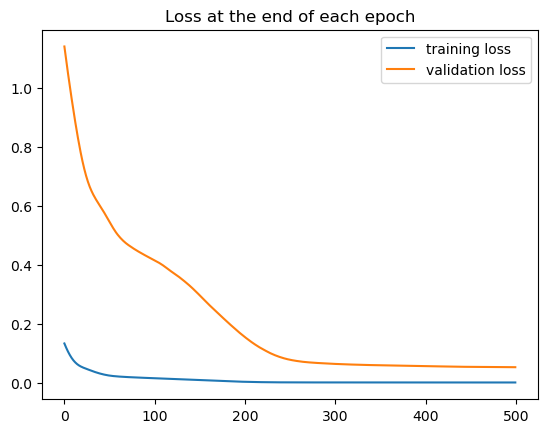

In [45]:
train_losses = [loss.item() for loss in losses]
validation_losses = [loss_.item() for loss_ in losses_] 

plt.plot(train_losses, label='training loss')
plt.plot(validation_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.legend()

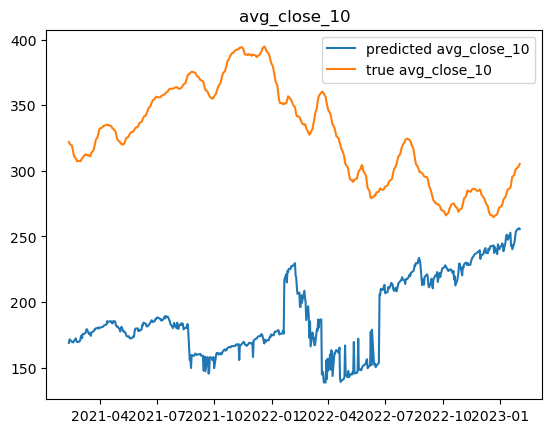

In [46]:
test_x = torch.tensor(test_data[["Close", "Volume", "ISM", "CPI"]].values, dtype=torch.float)
test_y = torch.tensor(test_data[["avg_10_Close", "avg_30_Close", "avg_60_Close"]].values, dtype=torch.float)

model.eval()
with torch.no_grad():
    y_pred_t = model.forward(test_x)
    
    test_10 = y_pred_[:,0]
    test_30 = y_pred_[:,1]
    test_60 = y_pred_[:,2]
    
avg_c10_p = [c.item() for c in test_10]
avg_c10_t = [c.item() for c in test_y[:, 0]]

avg_10_p = scaler_c_10.inverse_transform(np.array(avg_c10_p).reshape(-1, 1))
avg_10_t = scaler_c_10.inverse_transform(np.array(avg_c10_t).reshape(-1, 1))

plt.plot(test_data.index, avg_10_p, label='predicted avg_close_10')
plt.plot(test_data.index, avg_10_t, label='true avg_close_10')
plt.title('avg_close_10')
plt.legend()

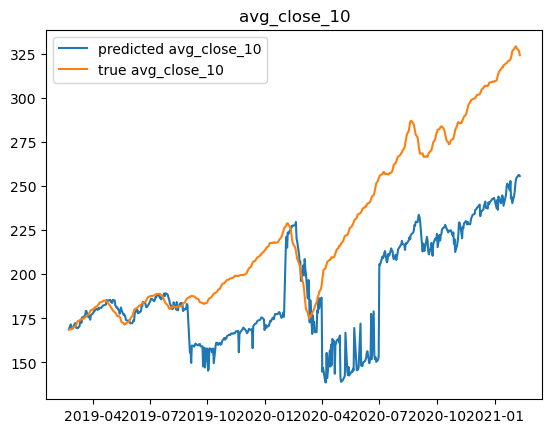

In [47]:
model.eval()
with torch.no_grad():
    y_pred_t = model.forward(validation_x)
    
    val_10 = y_pred_[:,0]
    val_30 = y_pred_[:,1]
    val_60 = y_pred_[:,2]
    
avg_c10_p = [c.item() for c in val_10]
avg_c10_t = [c.item() for c in validation_y[:, 0]]

avg_10_p = scaler_c_10.inverse_transform(np.array(avg_c10_p).reshape(-1, 1))
avg_10_t = scaler_c_10.inverse_transform(np.array(avg_c10_t).reshape(-1, 1))

plt.plot(validation_data.index, avg_10_p, label='predicted avg_close_10')
plt.plot(validation_data.index, avg_10_t, label='true avg_close_10')
plt.title('avg_close_10')
plt.legend()

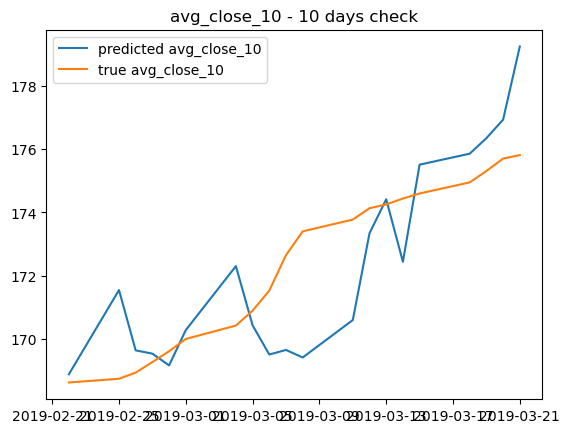

In [53]:
plt.plot(validation_data.index[:20], avg_10_p[:20], label='predicted avg_close_10')
plt.plot(validation_data.index[:20], avg_10_t[:20], label='true avg_close_10')
plt.title('avg_close_10 - 10 days check')
plt.legend()

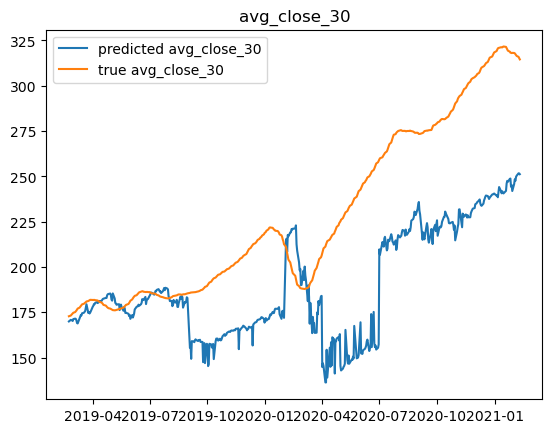

In [54]:
model.eval()
with torch.no_grad():
    y_pred_t = model.forward(validation_x)
    
    val_10 = y_pred_[:,0]
    val_30 = y_pred_[:,1]
    val_60 = y_pred_[:,2]
    
avg_c30_p = [c.item() for c in val_30]
avg_c30_t = [c.item() for c in validation_y[:, 1]]

avg_30_p = scaler_c_30.inverse_transform(np.array(avg_c30_p).reshape(-1, 1))
avg_30_t = scaler_c_30.inverse_transform(np.array(avg_c30_t).reshape(-1, 1))

plt.plot(validation_data.index, avg_30_p, label='predicted avg_close_30')
plt.plot(validation_data.index, avg_30_t, label='true avg_close_30')
plt.title('avg_close_30')
plt.legend()

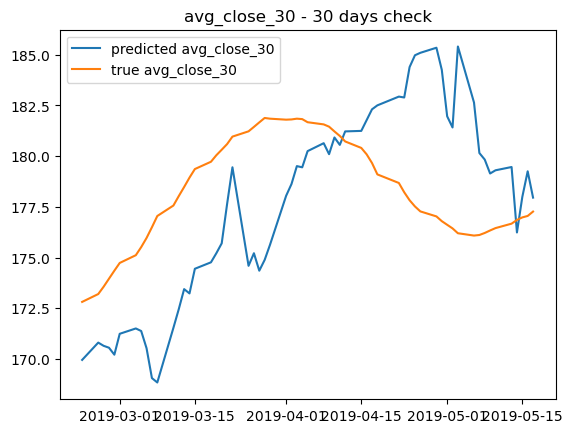

In [55]:
plt.plot(validation_data.index[:60], avg_30_p[:60], label='predicted avg_close_30')
plt.plot(validation_data.index[:60], avg_30_t[:60], label='true avg_close_30')
plt.title('avg_close_30 - 30 days check')
plt.legend()

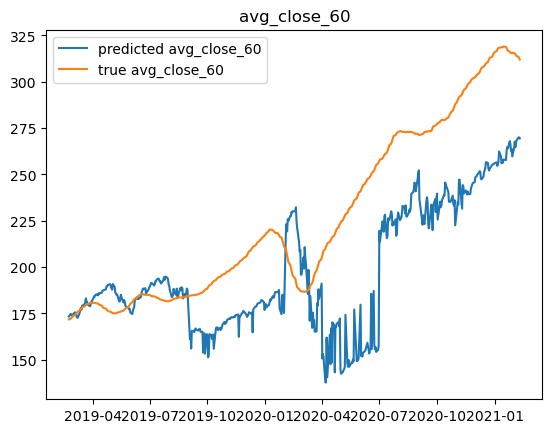

In [56]:
model.eval()
with torch.no_grad():
    y_pred_t = model.forward(validation_x)
    
    val_10 = y_pred_[:,0]
    val_30 = y_pred_[:,1]
    val_60 = y_pred_[:,2]
    
avg_c60_p = [c.item() for c in val_60]
avg_c60_t = [c.item() for c in validation_y[:, 1]]

avg_60_p = scaler_c_60.inverse_transform(np.array(avg_c60_p).reshape(-1, 1))
avg_60_t = scaler_c_60.inverse_transform(np.array(avg_c60_t).reshape(-1, 1))

plt.plot(validation_data.index, avg_60_p, label='predicted avg_close_60')
plt.plot(validation_data.index, avg_60_t, label='true avg_close_60')
plt.title('avg_close_60')
plt.legend()

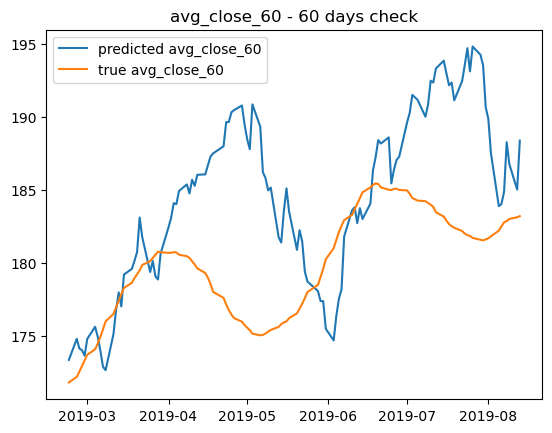

In [57]:
plt.plot(validation_data.index[:120], avg_60_p[:120], label='predicted avg_close_60')
plt.plot(validation_data.index[:120], avg_60_t[:120], label='true avg_close_60')
plt.title('avg_close_60 - 60 days check')
plt.legend()

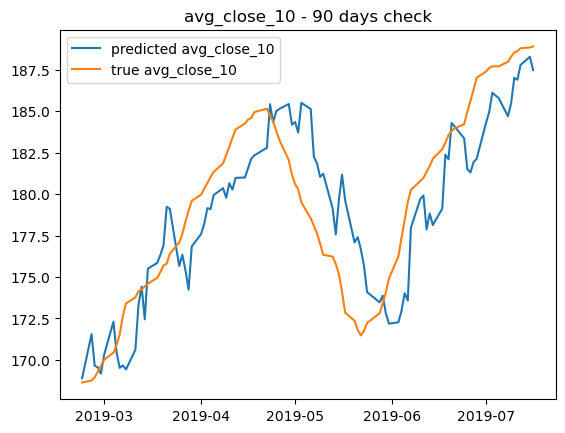

In [58]:
plt.plot(validation_data.index[:100], avg_10_p[:100], label='predicted avg_close_10')
plt.plot(validation_data.index[:100], avg_10_t[:100], label='true avg_close_10')
plt.title('avg_close_10 - 90 days check')
plt.legend()